In [1]:
import pickle
from pathlib import Path
import numpy as np
from src.img_utils import get_evd, draw_evd, Visualizer
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
exp_path = Path('exp_results')
i = 1
EXP_NAMES = ['deepmaxent_random', 'deepmaxent_active', 'deepmaxent_bald']
paths = [exp_path / f'{exp_name}_{i}' for exp_name in EXP_NAMES]
paths

[PosixPath('exp_results/deepmaxent_random_1'),
 PosixPath('exp_results/deepmaxent_active_1'),
 PosixPath('exp_results/deepmaxent_bald_1')]

In [13]:
all_evds = defaultdict(list)
all_his = defaultdict()
search_path_name = '*-train.pkl'
for exp_p, exp_name in zip(paths, EXP_NAMES):
    for i, p in enumerate(sorted(exp_p.glob(search_path_name))):
        with open(p, 'rb') as f:
            history = pickle.load(f)
        if i == len(list(exp_p.glob(search_path_name)))-1:
            all_his[exp_name] = history
        evds = get_evd(history)
        all_evds[exp_name].append(evds)
    all_evds[exp_name] = np.array(all_evds[exp_name])
    print(all_evds[exp_name].shape)

(8, 10)
(8, 10)
(8, 10)


In [14]:
def draw_all_evds(all_evds, file_path=None, figsize=(10, 4), dpi=120):
    '''evd_act.shape = evd_rand.shape = (# of experiments, n_trajs)'''
    title = 'Expected value difference'
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    for (exp_name, evd) in all_evds.items():
        n_trajs = evd.shape[1]
        idxs = np.arange(1, n_trajs+1, 1)
        evd_mean = evd.mean(axis = 0)
        evd_std = evd.std(axis = 0)
        sns.lineplot(x=idxs, y=evd_mean, label=exp_name)
        ax.fill_between(idxs, evd_mean - evd_std, evd_mean + evd_std, alpha=0.3)
    
    ax.set_xlabel('Number of acquistions samples')
    ax.set_ylabel('Expected value difference')
    
    ax.set_title(title)
    ax.set_xticks(idxs)
    ax.legend()
    if file_path is not None:
        fig.savefig((Path(file_path) / f'evd.png'))
    plt.tight_layout()    
    plt.show()

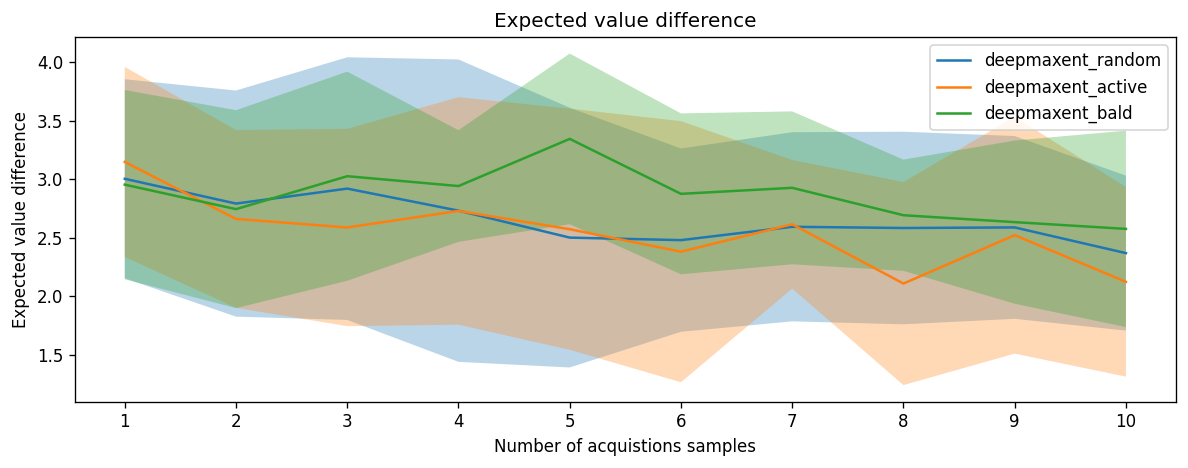

In [15]:
draw_all_evds(all_evds, figsize=(10, 4), dpi=120)